<a href="https://colab.research.google.com/github/baricio00/Health-Informatics-2025-26/blob/main/Copy_of_Lab_IV_SMHD_25_26_TBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size="6">Statistical Models for Healthcare Data</font>**

**<font size="5">MSc in Health Informatics - UniSR - A.Y. 2025-2026</font>**

Prof. Lara Cavinato - Dott. Vittorio Torri

---

<font size="4">Lab IV - Generalized Linear Models</font>

# Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

In [4]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
import statsmodels.api as sm

In [6]:
np.random.seed(1234)

In [7]:
import scipy.stats as stats

# Load Dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv('/content/drive/MyDrive/hf_dataset_lab_iv.csv')

In [14]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,bmi,rehospitalizations,ef_cat
0,75.00,0,582,0,20.73,1,265000.00,1.90,138.39,Male,0,4,True,30.82,4,reduced
1,55.00,0,7861,0,29.02,0,263358.03,1.10,131.90,Male,0,6,True,25.40,0,reduced
2,65.00,0,146,0,26.24,0,162000.00,1.30,143.66,Male,1,7,True,29.45,3,reduced
3,50.00,1,111,0,10.21,0,210000.00,1.90,135.03,Male,0,7,True,36.06,2,reduced
4,65.00,1,160,1,19.33,0,327000.00,2.70,136.08,Female,0,8,True,33.69,4,reduced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38.05,1,155000.00,1.10,135.58,Male,1,270,False,25.60,0,reduced
295,55.00,0,1820,0,35.20,0,270000.00,1.20,142.02,Female,0,271,False,29.39,2,reduced
296,45.00,0,2060,1,62.32,0,742000.00,0.80,136.38,Female,0,278,False,20.71,0,preserved
297,45.00,0,2413,0,37.49,0,140000.00,1.40,133.91,Male,1,280,False,27.76,1,reduced


In [15]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time', 'rehospitalizations']

# Binary Logistic Regression

We want to build a model to classify patients as dead or survived during follow-up: binary classification.

We use a logistic regression model, which models the probability of the positive class (death) in the following way, where $x_1, ..., x_p$ are the input variables.

We might be interested in having a model that consider additional variables that might be useful

$$
P(y = 1 | x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p)}}
$$


I have the $\beta$ multiplying the predictors. Generalized linear regression is an extended linear regression

## Model

In [16]:
X = df[['age', 'bmi', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'ejection_fraction', 'time', 'rehospitalizations']]
y = df['DEATH_EVENT'].astype(int) # Explicitly convert boolean DEATH_EVENT to int (True=1, False=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

train_index = X_train.index
test_index = X_test.index

We start using all numerical variables

In [17]:
X_train_1 = X_train[num_vars]
X_test_1 = X_test[num_vars]

X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

logit_model = sm.Logit(y_train, X_train_1).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.374937
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            9
Date:                Mon, 17 Nov 2025   Pseudo R-squ.:                  0.4063
Time:                        10:14:20   Log-Likelihood:                -89.610
converged:                       True   LL-Null:                       -150.95
Covariance Type:            nonrobust   LLR p-value:                 3.791e-22
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.0558      7.331     -0.690      0.490     -19.424

In [18]:
X_train_1 = X_train[num_vars]
X_test_1 = X_test[num_vars]

X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

logit_model = sm.Logit(y_train, X_train_1).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.374937
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            9
Date:                Mon, 17 Nov 2025   Pseudo R-squ.:                  0.4063
Time:                        10:14:20   Log-Likelihood:                -89.610
converged:                       True   LL-Null:                       -150.95
Covariance Type:            nonrobust   LLR p-value:                 3.791e-22
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.0558      7.331     -0.690      0.490     -19.424

If I see "Optimization terminated successfully", the optimization feature converge, so there is no need to add a constant.

"Log-Likelihood", "LL-Null" (no input variable) and "LLR p-value" should be very low, so it means I'm doing something useful.

The only difference is that we have a "z" value but we can ignore it. If I have P>|z| higher than 50%, maybe the variable is useless.

What's important is the interpretation. I could have $\beta_{age}$, but what I need is the exponent of each coefficient to interpret and understand the effect on the ouput in my model.

By default statsmodels uses the Newton-Raphson iterative optimization method to maximize the likelihood, but other methods can be specified

Statsmodels compute the pseudo R^2 statistics using the McFadden's definition:

$$pseudo_{R^2} = 1 - \frac{LL}{LL_{Null}}$$

It takes values from 0 to 1 and it indicates the goodness of the model, but it's not the primary metric used to evaluate LR models

## Odds Ratios

In a logistic model, the effect of the coefficient is different from a linear regression model. A k-unit increase in $x_j$ increases the risk by a factor of $exp(k \cdot \hat{\beta_j})$. Odds ratios are defined as:

$$
OR_j = exp(\hat{\beta_j})
$$

In [19]:
coef = logit_model.params
odds_ratios = np.exp(coef) # e^coef

conf = logit_model.conf_int() # get the confidence intervals
conf.columns = ['2.5%', '97.5%']
conf = np.exp(conf)  # Exponentiate the betas' CIs to get ORs' CIs

or_summary = pd.DataFrame({
    "Coefficient": coef,
    "Odds Ratio": odds_ratios,
    "2.5% CI OR": conf['2.5%'],
    "97.5% CI OR": conf['97.5%']
})

or_summary = or_summary.drop('const')
# if odds ratio is 1.05, there is an increase of 5% on the output
# every unit increasing in ef, having an odds ratio of 0.96, I'm reducing by 4% the prob of dying
# having an odds ratio of 1.00, means that I'm not adding anything to the output
# the serum creatinine = 1.51, adds much info, but have CI = 0.75, so we can't fully rely on this information

print(or_summary)

                          Coefficient  Odds Ratio  2.5% CI OR  97.5% CI OR
age                              0.05        1.05        1.01         1.09
creatinine_phosphokinase         0.00        1.00        1.00         1.00
ejection_fraction               -0.04        0.96        0.91         1.01
platelets                       -0.00        1.00        1.00         1.00
serum_creatinine                 0.41        1.51        0.75         3.06
serum_sodium                     0.02        1.02        0.93         1.11
bmi                              0.09        1.09        0.90         1.32
time                            -0.02        0.98        0.97         0.99
rehospitalizations               0.08        1.08        0.85         1.37


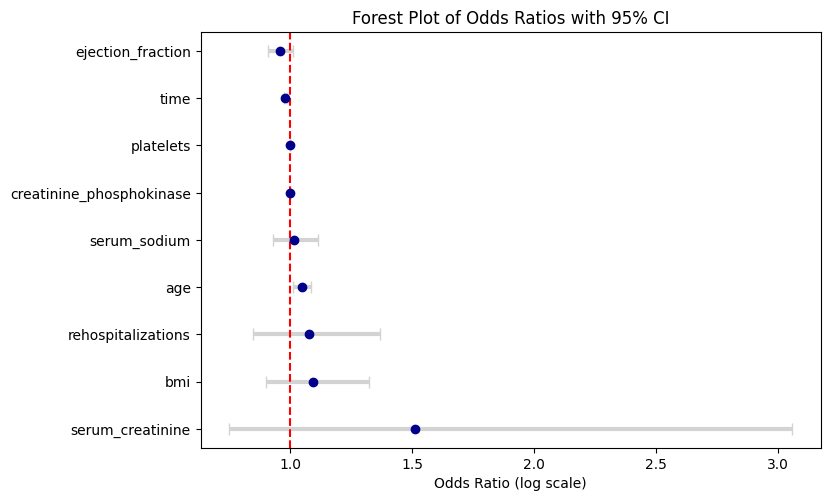

In [20]:
# Sort by odds ratio for better visualization
or_summary = or_summary.sort_values(by="Odds Ratio", ascending=False)

# The 'const' column was already dropped in a previous cell (0B3Y8DFwA3pA)
# so this line is redundant and causes a KeyError.
# or_summary = or_summary.drop('const')

fig, ax = plt.subplots(figsize=(8, len(or_summary) * 0.6))

# Plot the OR as points with confidence intervals
ax.errorbar(or_summary['Odds Ratio'], or_summary.index,
            xerr=[or_summary['Odds Ratio'] - or_summary['2.5% CI OR'], or_summary['97.5% CI OR'] - or_summary['Odds Ratio']],
            fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)

# Add a vertical line at OR = 1 (meaning no effect)
ax.axvline(1, color='red', linestyle='--')

ax.set_xlabel("Odds Ratio (log scale)")
ax.set_title("Forest Plot of Odds Ratios with 95% CI")
#ax.set_xscale("log")  # Log scale is sometimes useful for better visualization

plt.show()

platelets and creatine_phosphokinase are useless, but "rehospitalizations" is an issue because we can't understand if it's a protective effect. The age is slightly positive and above the red line, so it has small moderate effect of increasing the death event condition -> it's useful

## Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
y_test_pred_prob = logit_model.predict(X_test_1)
# we try to measure on the test set the performance of the model
# looking in the elements, I have probabilities as output.
# We might want turn them into binary values, because I'm treating categorical variables
# we set a threshold to define when the value must be 1 or 0

In [23]:
y_test_pred_prob

,0
73,0.30
110,0.33
291,0.02
168,0.18
289,0.02
124,0.77
286,0.02
164,0.26
296,0.00
261,0.01


Logistic regression is a probabilistic model, i.e. it outputs a probability of belonging to the "positive" class, but how do we turn this into a binary output? We need to define a threshold

In [24]:
threshold = 0.5
y_test_pred_class = (y_test_pred_prob > threshold).astype(int)
# how to define the threshold? Here's it's 0.5

In [25]:
y_test_pred_class

,0
73,0
110,0
291,0
168,0
289,0
124,1
286,0
164,0
296,0
261,0


In [26]:
print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test.astype(int), y_test_pred_class))

Confusion Matrix on Test Set:
[[38  4]
 [ 7 11]]


Remember the interpretation of a binary confusion matrix:

[  TN    FP  ]

[  FN    TP  ]

TN = True Negatives,
TP = True Positives,
FP = False Positives,
FN = False Negatives

With a better visualization:

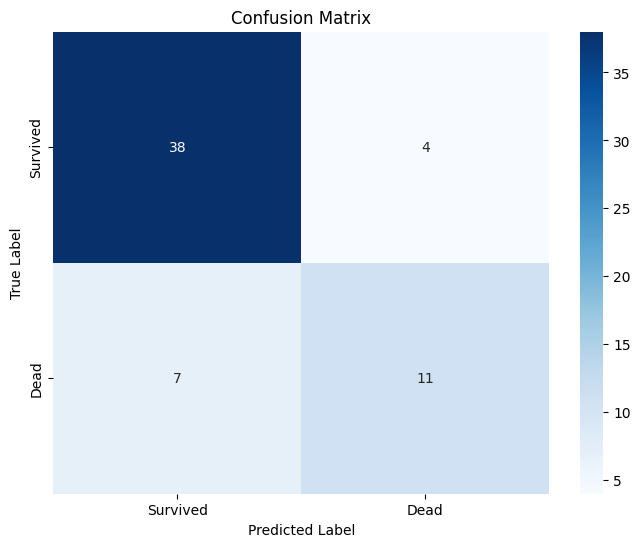

In [27]:
cm = confusion_matrix(y_test, y_test_pred_class)
# it's the way to understand what my model is doing

class_names = ['Survived', 'Dead']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## AUC

I want to have a model that is not influenced by a threshold

The Receiver-Operating-Characteristic Curve (ROC Curve) plots the FPR vs TPR at varying the classification threshold from 0 to 1, where

$$TPR = \frac{TP}{TP+FN} (= Sensitivity = Recall)$$

$$FPR = \frac{FP}{FP+TN}$$

Ok but TPR and FPR depend on classification threshold, because they change.

I draw a line on the plot, that defines the threshold for the AUC

The ideal point is (0,1), which minimizes the FPR and maximizes the TPR

The Area Under the Reveiver-Operating-Characteristic Curve (AUC-ROC or simply AUC) is a measure of goodness of the model that is not influences by the choice of a classification threshold

Let's first compute the TPR and FPR from the current confusion matrix, i.e. with threshold=0.5. We will use them later to compare

In [28]:
tn, fp, fn, tp = cm.ravel()
tpr_original = tp / (tp + fn) if (tp + fn) > 0 else 0.0
fpr_original = fp / (fp + tn) if (fp + tn) > 0 else 0.0
print(f'FPR={fpr_original}, TPR={tpr_original}')

FPR=0.09523809523809523, TPR=0.6111111111111112


Now let's plot the ROC curve

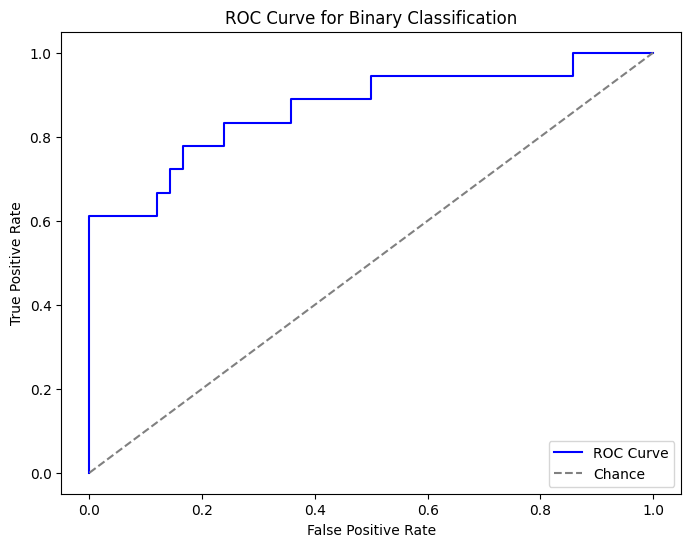

In [29]:
from sklearn.metrics import roc_curve

# computes the roc curve as a set of points (fpr, tpr)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob) # the third elements that it returns are the thresholds. roc_curve(target, probabilities)
# _ is for the threshold

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve")

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.show()

If I set a threshold at (0;0) I'm classifying everything as positive.

The line is useful, because if the AUC is under the line, I know that the model is doing very bad.

I want a model that is as near as possible to (0;1). The maximum area could be 1, as it's a rectangle

And compute the area below it

In [30]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_test_pred_prob)
print(f"ROC-AUC Score on Test Set: {auc_score}")

ROC-AUC Score on Test Set: 0.8677248677248678


## Accuracy, Precision, Recall/Sensitivity, F1-Score, Specificity

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = Sensitivity = TPR = \frac{TP}{TP+FN}$$
$$\text{F1-Score} = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$
$$Specificity = \frac{TN}{TN+FP}$$

If the accuracy is 0.7, the model is working correctly in 70% of the cases.

The higher the precision, the lower is the possibility to have mistakes, becuse I have less false positive.

The F1-score is between 0 and 1. It's the geometric precision of the model. It's affected on high precision or high recall.

The specificity (along with sensitivity) are important in healthcare data. It's the recall of the otehr classes. It's the percentage of people that are correctly flagged as negative in my data. The sensitivity tells how many people are correctly marked as positive

In [31]:
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_class, target_names=['Survived', 'Dead'], digits=4))

Classification Report on Test Set:
              precision    recall  f1-score   support

    Survived     0.8444    0.9048    0.8736        42
        Dead     0.7333    0.6111    0.6667        18

    accuracy                         0.8167        60
   macro avg     0.7889    0.7579    0.7701        60
weighted avg     0.8111    0.8167    0.8115        60



recall=0.6111 means there are some false negatives

What about the sensitivity? We can compute it explicitly, but it is already implicitly reported in the classification record...

In [32]:
# TODO

## Choice of the threshold

Using 0.5 as threshold is the most common choice, but it might not be the optimal one, especially in case of class unbalance

One suggest value is the percentage of negative samples

In [33]:
candidate_threshold_1 = 1 - df['DEATH_EVENT'].mean() # 1 - % of positive samples

In [34]:
candidate_threshold_1

np.float64(0.6789297658862876)

In [35]:
y_test_pred_class = (y_test_pred_prob > candidate_threshold_1).astype(int)

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred_class))

Confusion Matrix on Test Set:
[[42  0]
 [ 9  9]]


In [36]:
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred_class))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        42
           1       1.00      0.50      0.67        18

    accuracy                           0.85        60
   macro avg       0.91      0.75      0.78        60
weighted avg       0.88      0.85      0.83        60



Let's see where this threshold ends up on the ROC curve

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()

tpr_1 = tp / (tp + fn)  # Sensitivity or Recall or TPR
fpr_1 = fp / (fp + tn)  # False Positive Rate (FPR)

print(f'FPR={fpr_1}, TPR={tpr_1}')

FPR=0.0, TPR=0.5


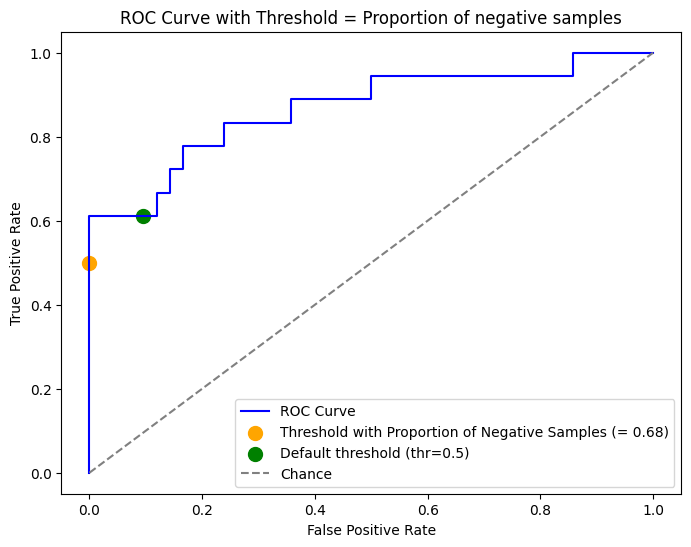

In [38]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve")

# Plot the point corresponding to the candidate threshold point
plt.scatter(fpr_1, tpr_1, color='orange', s=100, label=f"Threshold with Proportion of Negative Samples (= {candidate_threshold_1:.2f})")

# Plot the point corresponding to the original threshold point
plt.scatter(fpr_original, tpr_original, color='green', s=100, label=f"Default threshold (thr=0.5)")

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold = Proportion of negative samples")
plt.legend(loc="lower right")
plt.show()

What's better? There is no definitive answer

Another heuristic is the **maximization** of the **Youden's J index**, which is the *difference between TPR and FPR*

In [39]:
fpr, tpr, thresholds= roc_curve(y_test, y_test_pred_prob)

In [40]:
fpr

array([0.        , 0.        , 0.        , 0.11904762, 0.11904762,
       0.14285714, 0.14285714, 0.16666667, 0.16666667, 0.23809524,
       0.23809524, 0.35714286, 0.35714286, 0.5       , 0.5       ,
       0.85714286, 0.85714286, 1.        ])

In [41]:
tpr

array([0.        , 0.05555556, 0.61111111, 0.61111111, 0.66666667,
       0.66666667, 0.72222222, 0.72222222, 0.77777778, 0.77777778,
       0.83333333, 0.83333333, 0.88888889, 0.88888889, 0.94444444,
       0.94444444, 1.        , 1.        ])

In [42]:
thresholds

array([           inf, 9.52578795e-01, 6.25296181e-01, 3.70141179e-01,
       3.27286826e-01, 3.22701731e-01, 3.03180228e-01, 2.99067679e-01,
       2.96455427e-01, 2.77501371e-01, 2.59219794e-01, 1.56464907e-01,
       1.44067156e-01, 6.85144972e-02, 6.61818562e-02, 1.40611458e-02,
       1.36996314e-02, 5.48781569e-04])

In [43]:
youden_all = tpr - fpr
idx_best = np.argmax(youden_all)
best_thr = thresholds[idx_best]
best_J = youden_all[idx_best]
best_tpr, best_fpr = tpr[idx_best], fpr[idx_best]

print(f"Max Youden's J on ROC: {best_J:.4f} at threshold {best_thr:.4f} "
      f"(TPR={best_tpr:.4f}, FPR={best_fpr:.4f})")

Max Youden's J on ROC: 0.6111 at threshold 0.6253 (TPR=0.6111, FPR=0.0000)


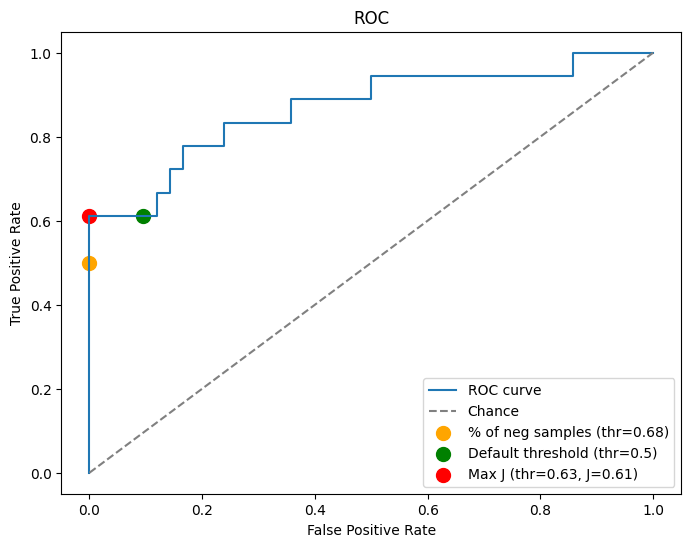

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

# % of negative points
plt.scatter(fpr_1, tpr_1, s=100, color='orange', label=f"% of neg samples (thr={candidate_threshold_1:.2f})")

# Original threshold point
plt.scatter(fpr_original, tpr_original, color='green', s=100, label=f"Default threshold (thr=0.5)")

# Maximize Youden's J
plt.scatter(best_fpr, best_tpr, s=100, color='red',
            label=f"Max J (thr={best_thr:.2f}, J={best_J:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

## A smaller model

TODO: Based on the output of the previous model, try to fit a smaller model and compute its performances

In [45]:
# TODO

# Multiclass logistic regression

We want to develop a model to classify HF patients in the three ejection fraction classes we defined in Lab II.

Multiclass logistic regression is an extended class of logistic regression

In [ ]:
df['ef_cat'] = pd.cut(df['ejection_fraction'], bins=[0,40,50, 100], labels=['reduced', 'mildly reduced', 'preserved'])

In [ ]:
df[['ejection_fraction', 'ef_cat']] # ejection fraction categorized
# it's udeful to have a model that predicts this class, as it's difficult to predict
# the more classes you have, the more complex the model, so the more is the need to build a model that performs well

,ejection_fraction,ef_cat
0,20.73,reduced
1,29.02,reduced
2,26.24,reduced
3,10.21,reduced
4,19.33,reduced
...,...,...
294,38.05,reduced
295,35.20,reduced
296,62.32,preserved
297,37.49,reduced


## Model

A multinomial logistic regression model assumes a baseline class (assume the *K*-th one without loss of generality) and computes a set of coefficients for each other class *k*:

$$
P(y = k | x) = \frac{e^{\beta_{k0} + \beta_{k1} x_1 + \beta_{k2} x_2 + \dots + \beta_{kp} x_p}}{1 + \sum_{j=1}^{K-1} e^{\beta_{j0} + \beta_{j1} x_1 + \beta_{j2} x_2 + \dots + \beta_{jp} x_p}} \quad\text{for }k < K \\
P(y = K | x) = \frac{1}{1 + \sum_{j=1}^{K-1} e^{\beta_{j0} + \beta_{j1} x_1 + \beta_{j2} x_2 + \dots + \beta_{jp} x_p}}
$$

At the denominator we have the sum of each class parameter. We have a set of parameters of each class except one

The multinomial logistic regression model implemented in the *statsmodels* library requires categorical input variables to be *one-hot encoded*

We'll have a set of betas for each class. $\beta_0$ for class 0, $\beta_1$ for class 1, nd so on.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)

In [ ]:
df_encoded

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,bmi,rehospitalizations,ef_cat,anaemia_1,diabetes_1,high_blood_pressure_1,sex_Male,smoking_1,DEATH_EVENT_True
0,75.00,582,20.73,265000.00,1.90,138.39,4,30.82,4,reduced,0,0,1,1,0,1
1,55.00,7861,29.02,263358.03,1.10,131.90,6,25.40,0,reduced,0,0,0,1,0,1
2,65.00,146,26.24,162000.00,1.30,143.66,7,29.45,3,reduced,0,0,0,1,1,1
3,50.00,111,10.21,210000.00,1.90,135.03,7,36.06,2,reduced,1,0,0,1,0,1
4,65.00,160,19.33,327000.00,2.70,136.08,8,33.69,4,reduced,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,61,38.05,155000.00,1.10,135.58,270,25.60,0,reduced,0,1,1,1,1,0
295,55.00,1820,35.20,270000.00,1.20,142.02,271,29.39,2,reduced,0,0,0,0,0,0
296,45.00,2060,62.32,742000.00,0.80,136.38,278,20.71,0,preserved,0,1,0,0,0,0
297,45.00,2413,37.49,140000.00,1.40,133.91,280,27.76,1,reduced,0,0,0,1,1,0


In [ ]:
X = df_encoded[['age', 'bmi', 'serum_sodium', 'serum_creatinine', 'diabetes_1', 'sex_Male', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1', 'rehospitalizations']]
y = df_encoded['ef_cat']  # Multiclass target variable

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [ ]:
y_train

,ef_cat
158,preserved
37,preserved
99,reduced
169,reduced
250,reduced
...,...
172,preserved
16,reduced
79,mildly reduced
48,reduced


In [ ]:
model = sm.MNLogit(y_train, X_train) # multinomial logit
result = model.fit()

print(result.summary())

# We have LLR p-value that is very low, meaning that our model contains something very useful
# The method decided to take the "ef_cat=mildly reduced"

Optimization terminated successfully.
         Current function value: 0.561230
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                 ef_cat   No. Observations:                  239
Model:                        MNLogit   Df Residuals:                      217
Method:                           MLE   Df Model:                           20
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.3629
Time:                        18:22:55   Log-Likelihood:                -134.13
converged:                       True   LL-Null:                       -210.53
Covariance Type:            nonrobust   LLR p-value:                 1.831e-22
ef_cat=mildly reduced       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    20.2181      7.343      2.753      0.006       5.826      34.

In [ ]:
result.params

# the classes are replaced with numbers (0 and 1)

,0,1
const,20.22,30.58
age,0.04,0.01
bmi,-0.34,-0.98
serum_sodium,-0.12,-0.10
serum_creatinine,1.72,3.73
diabetes_1,-0.10,0.63
sex_Male,0.44,-0.01
smoking_1,-0.15,0.70
high_blood_pressure_1,0.36,0.25
anaemia_1,-0.16,0.77


In [ ]:
model._ynames_map # in this way I get a dictionary with the name of the classes

{0: 'reduced', 1: 'mildly reduced', 2: 'preserved'}

In [ ]:
np.exp(result.params).rename(columns={0: 'mildly_reduced OR', 1:'preserved OR'})

# we have the odds ratio that are completely different from each other.

,mildly_reduced OR,preserved OR
const,603433842.85,19085530095918.32
age,1.04,1.01
bmi,0.72,0.37
serum_sodium,0.88,0.91
serum_creatinine,5.57,41.79
diabetes_1,0.90,1.88
sex_Male,1.56,0.99
smoking_1,0.86,2.00
high_blood_pressure_1,1.44,1.28
anaemia_1,0.85,2.17


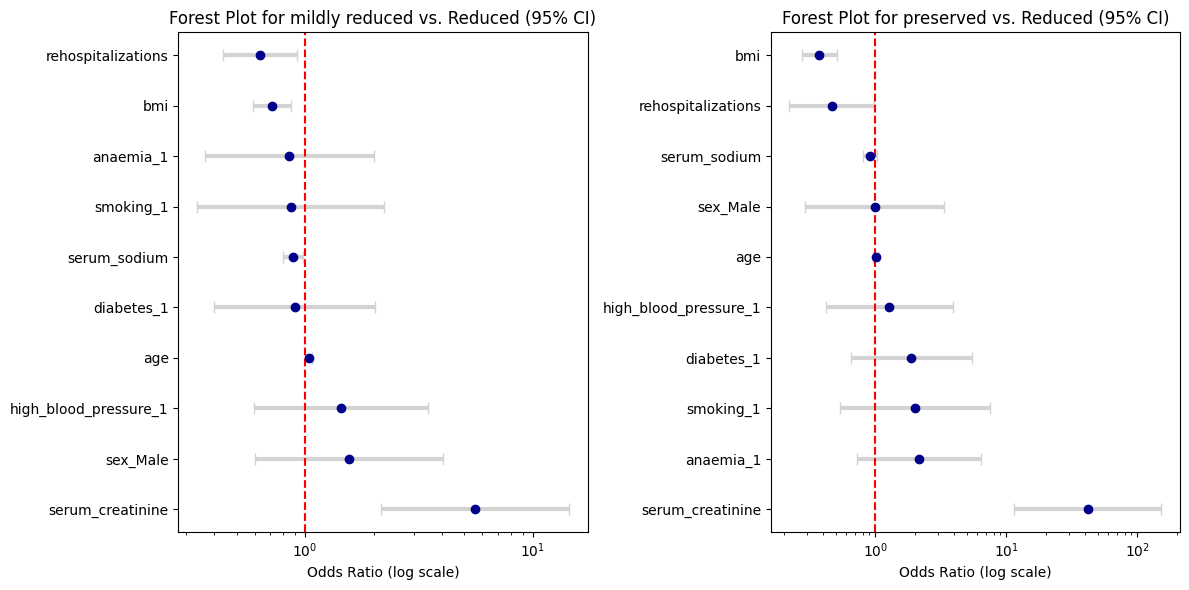

In [ ]:
# Assuming 'model' and 'result' objects are available from previous cells.

# Get the actual class names used as keys in the confidence interval DataFrame
estimated_class_names = result.conf_int().index.get_level_values(0).unique()

fig, axs = plt.subplots(1, len(estimated_class_names), figsize=(6 * len(estimated_class_names), 6))

# Ensure axs is iterable even if there's only one subplot
if len(estimated_class_names) == 1:
    axs = [axs]

for i, class_name_str in enumerate(estimated_class_names):
    # current_class_params_col_idx corresponds to the integer column index in result.params
    # assuming the order in estimated_class_names matches the column order (0, 1, ...)
    current_class_params_col_idx = i

    coef = result.params.iloc[:, current_class_params_col_idx] # Access by integer position
    odds_ratios = np.exp(coef)

    # Get confidence intervals for the current class from the result object
    conf_raw = result.conf_int()
    # Filter for the current class_name_str. result.conf_int() has a MultiIndex.
    conf_class_filtered = conf_raw.loc[class_name_str] # Use string name for MultiIndex loc

    # Exponentiate the confidence intervals
    conf_exp = np.exp(conf_class_filtered)

    or_summary = pd.DataFrame({
        "Coefficient": coef,
        "Odds Ratio": odds_ratios,
        "2.5% CI OR": conf_exp.iloc[:, 0], # Access by integer position
        "97.5% CI OR": conf_exp.iloc[:, 1]  # Access by integer position
    })

    # Drop the 'const' row for plotting as it's typically not interpreted as an OR
    or_summary = or_summary.drop('const')

    # Sort by odds ratio for better visualization
    or_summary = or_summary.sort_values(by="Odds Ratio", ascending=False)

    # Plot on the corresponding subplot
    ax = axs[i]
    ax.errorbar(or_summary['Odds Ratio'], or_summary.index,
                xerr=[or_summary['Odds Ratio'] - or_summary['2.5% CI OR'], or_summary['97.5% CI OR'] - or_summary['Odds Ratio']],
                fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)

    # Add a vertical line at OR = 1 (meaning no effect)
    ax.axvline(1, color='red', linestyle='--')
    ax.set_xlabel("Odds Ratio (log scale)")
    ax.set_title(f"Forest Plot for {class_name_str} vs. Reduced (95% CI)")
    ax.set_xscale("log") # Log scale is essential for better visualization of ORs

plt.tight_layout()
plt.show()

## Test set evaluation

In [ ]:
y_test_pred_prob = result.predict(X_test)  # Returns probabilities for each class

y_test_pred_prob.rename(model._ynames_map, axis='columns', inplace=True)

y_test_pred_class = y_test_pred_prob.idxmax(axis=1) #for each sample, assign the class with maximum probability

In [ ]:
y_test_pred_prob

,reduced,mildly reduced,preserved
170,0.96,0.04,0.00
237,0.94,0.06,0.00
218,0.93,0.06,0.00
228,0.95,0.05,0.00
264,0.30,0.25,0.45
129,0.43,0.25,0.32
97,0.06,0.10,0.84
139,0.80,0.16,0.03
193,0.97,0.03,0.00
39,0.95,0.04,0.00


In [ ]:
#example
print(y_test_pred_prob.iloc[0])
print(y_test_pred_class.iloc[0])

reduced          0.96
mildly reduced   0.04
preserved        0.00
Name: 170, dtype: float64
reduced


In [ ]:
y_test

,ef_cat
170,reduced
237,reduced
218,reduced
228,reduced
264,mildly reduced
129,mildly reduced
97,preserved
139,reduced
193,reduced
39,reduced


In [ ]:
y_test_pred_class

,0
170,reduced
237,reduced
218,reduced
228,reduced
264,preserved
129,reduced
97,preserved
139,reduced
193,reduced
39,reduced


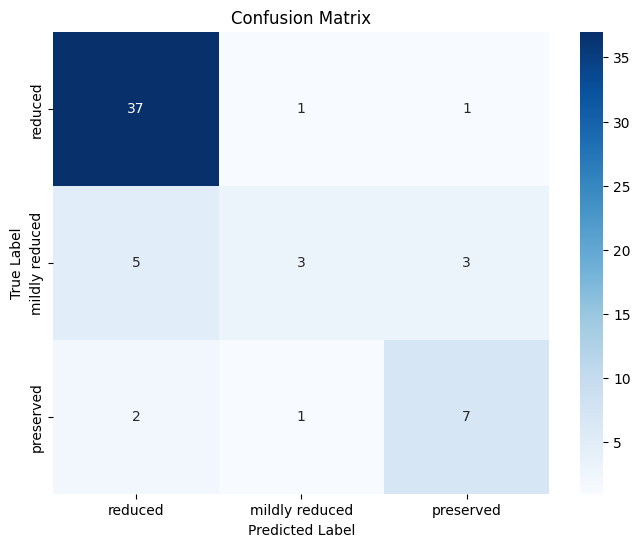

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

cm = confusion_matrix(y_test, y_test_pred_class, labels=list(model._ynames_map.values()))

class_names = model._ynames_map.values()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_class))


Classification Report:
                precision    recall  f1-score   support

mildly reduced       0.60      0.27      0.38        11
     preserved       0.64      0.70      0.67        10
       reduced       0.84      0.95      0.89        39

      accuracy                           0.78        60
     macro avg       0.69      0.64      0.64        60
  weighted avg       0.76      0.78      0.76        60



In a multiclass context, the ROC-AUC can be computed per class with a one-vs-all approach

In [ ]:
# Map y_test (multiclass categorical strings) to numerical labels (0, 1, 2)
class_mapping = {class_name: idx for idx, class_name in enumerate(model._ynames_map.values())}
y_test_numerical = y_test.map(class_mapping)

# Rename columns of y_test_pred_prob to match numerical labels (0, 1, 2)
y_test_pred_prob_numerical = y_test_pred_prob.rename(columns=class_mapping)

# Compute ROC AUC for each class (one-vs-all)
roc_auc_scores = {}
for i in (y_test_pred_prob_numerical.columns):
    # For one-vs-all, treat class i as positive (1) and all others as negative (0)
    # y_test_numerical == i will produce a boolean series, which sklearn accepts
    roc_auc = roc_auc_score(y_test_numerical == i, y_test_pred_prob_numerical.loc[:, i])
    roc_auc_scores[model._ynames_map[i]] = roc_auc # Map back to original class names for display

# Output the ROC AUC scores
for class_name, auc in roc_auc_scores.items():
    print(f'ROC AUC for {class_name}: {auc:.2f}')

ROC AUC for reduced: 0.95
ROC AUC for mildly reduced: 0.80
ROC AUC for preserved: 0.95


An aggregate ROC-AUC can be computed in different ways

In [ ]:
y_test = y_test.map({'reduced': 0, 'mildly reduced': 1, 'preserved': 2})
y_test_pred_prob.rename(columns={'reduced': 0, 'mildly reduced': 1, 'preserved': 2}, inplace=True)

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='micro', multi_class='ovr')
print(f'Micro-average ROC AUC: {roc_auc_micro:.2f}')

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='macro', multi_class='ovr')
print(f'Macro-average ROC AUC: {roc_auc_micro:.2f}')

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='weighted', multi_class='ovr')
print(f'Weighted-average ROC AUC: {roc_auc_micro:.2f}')

Micro-average ROC AUC: 0.94
Macro-average ROC AUC: 0.90
Weighted-average ROC AUC: 0.92


\begin{array}{|c|c|c|c|}
\hline
\textbf{Aspect} & \textbf{Macro-Averaging} & \textbf{Micro-Averaging} & \textbf{Weighted Averaging} \\
\hline
\textbf{Calculation} & \text{Average of individual class metrics} & \text{Aggregated metrics across all classes} & \text{Average of class metrics weighted by class size} \\
\hline
\textbf{Class Weighting} & \text{Treats all classes equally} & \text{Larger classes have more influence} & \text{Larger classes influence the average more} \\
\hline
\textbf{Performance Insight} & \text{Insight into performance of each class} & \text{Overall performance across the entire dataset} & \text{Balanced evaluation considering class sizes} \\
\hline
\textbf{Sensitivity} & \text{Sensitive to class imbalance} & \text{More robust to class imbalance} & \text{Moderately sensitive to class imbalance} \\
\hline
\textbf{Use Cases} & \text{Class-specific performance} & \text{Overall model performance} & \text{Balanced performance in imbalanced datasets} \\
\hline
\end{array}


$$
\text{Precision}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FP}_i)}
$$

$$
\text{Recall}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FN}_i)}
$$

$$
\text{F1}_{\text{micro}} = 2 \times \frac{\text{Precision}_{\text{micro}} \times \text{Recall}_{\text{micro}}}{\text{Precision}_{\text{micro}} + \text{Recall}_{\text{micro}}}
$$


Use macro when:

*  You care about per-class behavior, and you want to treat all classes equally, regardless of their frequency.

*  You want to evaluate model fairness across all classes, including rare or underrepresented ones.

*  You're dealing with imbalanced data, and you want to make sure small classes still matter in the evaluation.

*  You want to highlight weaknesses in your model’s performance on rare classes.



Use micro when:

*  You don't care about classes individually.

* You only care about total prediction quality.

* You are working with highly multilabel settings (many labels per sample).

* You want one simple number for "How many labels did I guess right?".

Use weighted when:

* You do care about per-class behavior.

* You want a summary that adjusts for imbalance but still thinks per-class.

* You have imbalanced classes, but you still want per-class precision/recall insight.

## Change baseline class

Manually encoding the target variable allows us to change the order of the numerical labels and consequently change the variable used as base

In [ ]:
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)
df_encoded['ef_cat'] = pd.Categorical(df['ef_cat'], categories=['mildly reduced', 'preserved', 'reduced'], ordered=True)

In [ ]:
X = df_encoded[['age', 'bmi', 'serum_sodium', 'serum_creatinine', 'diabetes_1', 'sex_Male', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1']]
y = df_encoded['ef_cat']  # Multiclass target variable

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [ ]:
model = sm.MNLogit(y_train, X_train)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.625371
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                 ef_cat   No. Observations:                  239
Model:                        MNLogit   Df Residuals:                      219
Method:                           MLE   Df Model:                           18
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.2901
Time:                        18:22:56   Log-Likelihood:                -149.46
converged:                       True   LL-Null:                       -210.53
Covariance Type:            nonrobust   LLR p-value:                 1.657e-17
     ef_cat=preserved       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.8485      8.602      0.912      0.362      -9.011      24.

In [ ]:
model._ynames_map

{0: 'mildly reduced', 1: 'preserved', 2: 'reduced'}

In [ ]:
np.exp(result.params).rename(columns={0: 'preserved OR', 1:'reduced OR'})

,preserved OR,reduced OR
const,2561.99,0.00
age,0.97,0.98
bmi,0.57,1.40
serum_sodium,1.04,1.09
serum_creatinine,3.89,0.32
diabetes_1,2.00,1.09
sex_Male,0.60,0.63
smoking_1,2.03,1.43
high_blood_pressure_1,0.77,1.05
anaemia_1,2.25,1.64


# Poisson Regression

We want a model for the number of reshospitalizations in 90 days. This is an integer count, that can be modelled with a Poisson variable.

$$ Y \sim \text{Poisson}(\lambda) \quad \text{where} \quad \lambda = e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p} $$


## Model

In [ ]:
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)

In [ ]:
df_encoded

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,bmi,rehospitalizations,ef_cat,anaemia_1,diabetes_1,high_blood_pressure_1,sex_Male,smoking_1,DEATH_EVENT_True
0,75.00,582,20.73,265000.00,1.90,138.39,4,30.82,4,reduced,0,0,1,1,0,1
1,55.00,7861,29.02,263358.03,1.10,131.90,6,25.40,0,reduced,0,0,0,1,0,1
2,65.00,146,26.24,162000.00,1.30,143.66,7,29.45,3,reduced,0,0,0,1,1,1
3,50.00,111,10.21,210000.00,1.90,135.03,7,36.06,2,reduced,1,0,0,1,0,1
4,65.00,160,19.33,327000.00,2.70,136.08,8,33.69,4,reduced,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,61,38.05,155000.00,1.10,135.58,270,25.60,0,reduced,0,1,1,1,1,0
295,55.00,1820,35.20,270000.00,1.20,142.02,271,29.39,2,reduced,0,0,0,0,0,0
296,45.00,2060,62.32,742000.00,0.80,136.38,278,20.71,0,preserved,0,1,0,0,0,0
297,45.00,2413,37.49,140000.00,1.40,133.91,280,27.76,1,reduced,0,0,0,1,1,0


In [ ]:
input_vars = ['age', 'sex_Male', 'bmi', 'ejection_fraction', 'serum_sodium', 'serum_creatinine', 'creatinine_phosphokinase',
              'diabetes_1', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1']


X = df_encoded[input_vars]
y = df_encoded['rehospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

train_index = X_train.index
test_index = X_test.index

X_train_1 = X_train[input_vars]
X_test_1 = X_test[input_vars]
X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

# Fit Poisson regression model
poisson_model = sm.GLM(y_train, X_train_1, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     rehospitalizations   No. Observations:                  239
Model:                            GLM   Df Residuals:                      227
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.41
Date:                Sat, 15 Nov 2025   Deviance:                       263.97
Time:                        18:22:56   Pearson chi2:                     253.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9341
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Rate Ratios

Similarly to logistic regression models, in poisson models there are Rate Ratios (RR) instead of Odds Ratios (OR). A k-unit increase in $x_j$ increases the count by a factor of $exp(k \cdot \hat{\beta_j})$. Rate ratios are defined as:

$$
RR_j = exp(\hat{\beta_j})
$$

In [ ]:
params = poisson_model.params
conf = poisson_model.conf_int()
conf['Rate Ratio'] = np.exp(params)
conf.columns = ['2.5%', '97.5%', 'Rate Ratio']
conf['2.5%'] = np.exp(conf['2.5%'])
conf['97.5%'] = np.exp(conf['97.5%'])
print(conf)

                          2.5%  97.5%  Rate Ratio
const                     0.93 835.84       27.90
age                       1.02   1.04        1.03
sex_Male                  0.76   1.26        0.98
bmi                       1.02   1.09        1.05
ejection_fraction         0.93   0.96        0.94
serum_sodium              0.94   0.99        0.96
serum_creatinine          1.14   1.36        1.25
creatinine_phosphokinase  1.00   1.00        1.00
diabetes_1                0.99   1.55        1.24
smoking_1                 1.07   1.71        1.35
high_blood_pressure_1     1.13   1.74        1.41
anaemia_1                 1.16   1.79        1.44


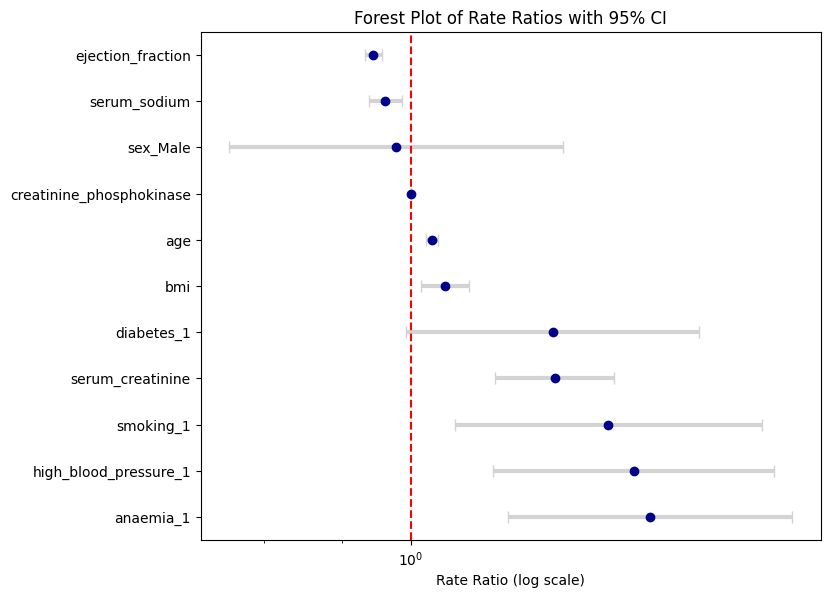

In [ ]:
conf = conf.sort_values(by="Rate Ratio", ascending=False)
conf['variable'] = conf.index

conf = conf[conf.variable != 'const']


# Plot
fig, ax = plt.subplots(figsize=(8, len(conf) * 0.6))
ax.errorbar(conf['Rate Ratio'], conf.index,
            xerr=[conf['Rate Ratio'] - conf['2.5%'], conf['97.5%'] - conf['Rate Ratio']],
            fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)
ax.axvline(1, color='red', linestyle='--')
ax.set_xlabel("Rate Ratio (log scale)")
ax.set_title("Forest Plot of Rate Ratios with 95% CI")
ax.set_xscale("log")
plt.show()

## Test set evaluation

Since the parameter $\lambda$ of the Poisson distribution is also its mean, to compute the output on a new observation the $\hat{\lambda}$ for the that observation is used, i.e.

$$\hat{y} = \hat{\lambda} = exp(\beta_0 + \beta_1 \cdot x_1 + ... + \beta_p \cdot x_p)$$

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$
$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$


MSE emphasizes larger errors more, while MAE provides an average error magnitude.

In [ ]:
# TODO compute MSE and MAE on the test set

In [ ]:
y_pred

NameError: name 'y_pred' is not defined

In [ ]:
np.round(y_pred)

# Feedback

Please leave a feedback on this lab through [this form](https://forms.office.com/e/WuD3i9GtgH) (estimated 2 minutes)

# Task
Create two forest plots to visualize the odds ratios and their 95% confidence intervals for the 'mildly reduced' and 'preserved' classes from the multinomial logistic regression model, using the 'reduced' class as the baseline.

## Plot Multinomial Odds Ratios

### Subtask:
Extract coefficients and confidence intervals for 'mildly reduced' and 'preserved' classes from the multinomial logistic regression model, calculate odds ratios and their confidence intervals, and then generate two forest plots to visualize these odds ratios for each class against the baseline 'reduced' class.


## Summary:

### Data Analysis Key Findings
*   Coefficients and their 95% confidence intervals were successfully extracted from the multinomial logistic regression model for the 'mildly reduced' and 'preserved' classes, using the 'reduced' class as the baseline.
*   Odds ratios (ORs) and their corresponding 95% confidence intervals were computed for each predictor variable within both the 'mildly reduced' and 'preserved' classes.
*   Two distinct forest plots were generated to visually represent these odds ratios and their 95% confidence intervals, providing a clear comparison for the 'mildly reduced' and 'preserved' heart failure phenotypes against the 'reduced' baseline.

### Insights or Next Steps
*   The generated forest plots will enable a straightforward visual identification of predictor variables that significantly influence the odds of belonging to the 'mildly reduced' or 'preserved' classes compared to the 'reduced' class (i.e., confidence intervals not crossing 1).
*   The next step should involve interpreting these forest plots to identify key demographic, clinical, or echocardiographic factors that are strong discriminators between the three heart failure phenotypes.
